In [1]:
%load_ext autoreload
%autoreload 2

In [140]:
from __future__ import absolute_import, division, print_function, unicode_literals

from dotenv import load_dotenv
load_dotenv()

import os
import sys

import numpy as np
import datetime
import pathlib
from pathlib import Path
import matplotlib.pyplot as plt

# tensorflow-gpu 2.0.0
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, Conv2D
from tensorflow.keras.layers import BatchNormalization, ReLU
from tensorflow.keras.optimizers import *
import tensorflow_probability as tfp
from scipy.ndimage import gaussian_filter

from brainage.io.dataset import AgeData
from brainage.misc import utils
from brainage.misc.utils import init_gpu, add_dataset_config
from brainage.models import keras_model_regression
from brainage.models import keras_evaluation
import brainage.test


In [137]:
a=brainage.test.hi()
a

hi


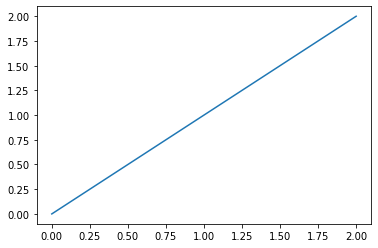

In [139]:
plt.plot([0,1,2])

In [67]:
keras_evaluation.test()

hi


In [14]:
# Initialize GPU 
init_gpu(gpu_device='0')

2.0.0


In [141]:
# Parameters
batch_size = 16
mc_samples = 50
# Switch between test and validation set
select_testset = True
select_dataset = 'IXI'
select_group = 'AD'
select_cv_split = 0
select_test_part = 'split'
config = {
        # General parameters
        'image_size': [100, 120, 100],
        'image_spacing': [1.5, 1.5, 1.5],
    }

image_size = config['image_size']
image_spacing = config['image_spacing']

config = add_dataset_config(config,
                            dataset=select_dataset,
                            split=select_cv_split,
                            ADNI_test_selection=select_test_part,
                            ADNI_group=select_group)

# Load training and test data.
age_data = AgeData(config,
                   shuffle_training_images=True,
                   save_debug_images=False,
                   select_testset=select_testset,
                   default_processing=True)
dataset_train = age_data.dataset_train()
train_samples = dataset_train.num_entries()
dataset_val = age_data.dataset_val()
val_samples = dataset_val.num_entries()
print(train_samples, val_samples)

def disturb(image):
    affine = np.diag((1, 2, 3, 1))
    affine[:3, 3] = 40, 50, 60
    sample = {
        't1': dict(
            #data=np.random.rand(*shape),
            data=image,
            affine=affine,
            type=INTENSITY,
            stem='t1',
        )
    }

    transform = torchio.RandomMotion(
        proportion_to_augment=1.0,
        seed=42,)
    transformed = transform(sample)
    return transformed['t1']['data'].numpy()
    
# Define training and validation datasets from generators.
def train_gen():
    data = dataset_train
    i = 0
    while i < data.num_entries():
        sample = data.get_next()
        # DHWC tensor format
        image = sample['generators']['image'].transpose([1, 2, 3, 0])
        image = image.astype('float32')
        age = sample['generators']['age']
        yield image, age
        i += 1

def val_gen():
    data = dataset_val
    i = 0
    while i < data.num_entries():
        sample = data.get_next()
        image = sample['generators']['image'].transpose([1, 2, 3, 0])
        #image = gaussian_filter(sample['generators']['image'].transpose([1, 2, 3, 0]), sigma=9.0)# (sample['generators']['image']).transpose([1, 2, 3, 0])
        #image = np.random.rand(*image.shape)
        image = image.astype('float32')
        age = sample['generators']['age']
        yield image, age
        i += 1

ds_train = tf.data.Dataset.from_generator(train_gen,
                                          output_types=(tf.float32, tf.float32),
                                          output_shapes=(tf.TensorShape((None, None, None, None)),
                                                         tf.TensorShape((1, ))))
ds_train = ds_train.batch(batch_size=batch_size)

ds_val = tf.data.Dataset.from_generator(val_gen,
                                        output_types=(tf.float32, tf.float32),
                                        output_shapes=(tf.TensorShape((None, None, None, None)),
                                                       tf.TensorShape((1, ))))
ds_val = ds_val.batch(batch_size=batch_size)

sample =next(iter(ds_val))

True
/mnt/share/raheppt1/project_data/brain/IXI/IXI_T1/config/IXI_T1_val_split0.csv
.csv a
loaded 416 ids
/mnt/share/raheppt1/project_data/brain/IXI/IXI_T1/config/IXI_T1_test.csv
.csv a
loaded 100 ids
416 100


In [19]:
prior_scale = 1.0
def prior(dtype, shape, name, trainable, add_variable_fn):
    loc = tf.zeros(shape)
    scale = tf.ones(shape) * prior_scale
    prior_dist = tfp.distributions.Normal(loc=loc, scale=scale)
    prior_dist = tfp.distributions.Independent(prior_dist,
                                               reinterpreted_batch_ndims=tf.size(prior_dist.batch_shape_tensor()))
    return prior_dist

bayesian_model = keras_model_regression.build_bayesian_model(image_size + [1],
                                                     prior=prior,
                                                     flipout=False,
                                                     outputs=1)

checkpoint_path = Path('/mnt/share/raheppt1/tf_models/brainage/keras/new_bayesian_08/')
latest = tf.train.latest_checkpoint(checkpoint_path)
print(latest)
bayesian_model.load_weights(str(latest))

/mnt/share/raheppt1/tf_models/brainage/keras/new_bayesian_08/cp2332-4.40


In [20]:
def mean_mae(y_true, y_pred):
    return tf.keras.losses.MAE(y_true[:, 0], y_pred[:, 0])

def mean_mse(y_true, y_pred):
    return tf.keras.losses.MSE(y_true[:, 0], y_pred[:, 0])

preds_list = []
preds_std_list = []
labels_list = []

for test_images, test_labels in ds_val:
    preds = list()
    # Multiple forward runs
    for i in range(mc_samples):
        preds.append(bayesian_model(test_images, training=False))
    preds = tf.stack(preds, axis=0).numpy()
    preds_std = np.quantile(preds, 0.7, axis=0)- np.quantile(preds, 0.3, axis=0)
    preds = np.mean(preds, axis=0, keepdims=False)
    preds_list.append(preds)
    preds_std_list.append(preds_std)
    labels_list.append(test_labels)
    print(np.mean(preds_std))
    print(mean_mae(test_labels, preds))
    print(mean_mse(test_labels, preds))
all_labels = tf.concat(labels_list, axis=0)
all_preds = tf.concat(preds_list, axis=0)
all_preds_std = tf.concat(preds_std_list, axis=0)

4.4810504674911495
tf.Tensor(15.754877, shape=(), dtype=float32)
tf.Tensor(310.8686, shape=(), dtype=float32)
4.74239354133606
tf.Tensor(11.776676, shape=(), dtype=float32)
tf.Tensor(203.84595, shape=(), dtype=float32)
5.221715760231017
tf.Tensor(10.700928, shape=(), dtype=float32)
tf.Tensor(156.01126, shape=(), dtype=float32)
4.06009817123413
tf.Tensor(13.273436, shape=(), dtype=float32)
tf.Tensor(224.3052, shape=(), dtype=float32)
4.245244550704955
tf.Tensor(13.023443, shape=(), dtype=float32)
tf.Tensor(245.43475, shape=(), dtype=float32)
3.8110913753509523
tf.Tensor(13.95435, shape=(), dtype=float32)
tf.Tensor(263.71796, shape=(), dtype=float32)
3.654885387420654
tf.Tensor(14.155747, shape=(), dtype=float32)
tf.Tensor(256.74838, shape=(), dtype=float32)


In [23]:
pathlib.Path(__file__)

NameError: name '__file__' is not defined

In [21]:
np.concatenate((all_labels[:20], all_preds[:20],all_preds_std[:20] ), axis=1)

array([[39.17590714, 45.0059166 ,  3.22016602],
       [41.88911819, 49.84075165,  4.9208889 ],
       [27.01437378, 48.02430725,  3.59413109],
       [68.13415527, 39.16968918,  4.60155678],
       [72.30664062, 39.73550034,  5.73760796],
       [65.40999603, 49.0935936 ,  4.78030396],
       [59.78371048, 49.41828918,  4.92556381],
       [28.87063599, 39.74868011,  4.77727661],
       [65.09513855, 48.31460571,  4.36637421],
       [30.18206787, 38.78928375,  5.09661713],
       [23.84667969, 47.71665955,  3.17445412],
       [63.39219666, 39.67353821,  4.73057671],
       [42.22039795, 48.80573273,  4.24454956],
       [63.81656265, 47.98884583,  3.91104813],
       [24.34223175, 36.63308716,  4.89201202],
       [60.0739212 , 49.56323624,  4.7236805 ],
       [46.22039795, 40.93923187,  5.74454994],
       [72.59411621, 50.78928757,  4.24099236],
       [41.13073349, 46.70678329,  4.8824707 ],
       [54.21492004, 49.7474823 ,  3.98660698]])

In [22]:
mean_mae(all_preds, all_labels)

<tf.Tensor: id=229649, shape=(), dtype=float32, numpy=13.123624>

In [177]:
np.mean(all_preds_std)

6.75457936477661

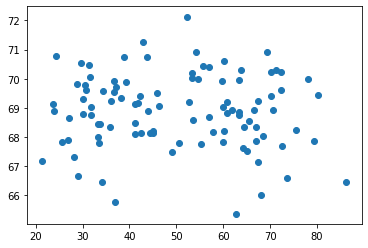

In [178]:
plt.scatter(all_labels, all_preds)

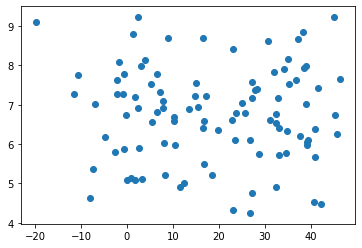

In [179]:
plt.scatter(all_preds-all_labels, all_preds_std)

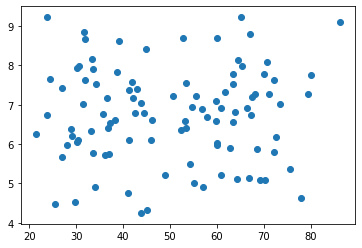

In [180]:
plt.scatter(all_labels, all_preds_std)

In [181]:
import torchio
from torchio import INTENSITY, LABEL, DATA
import numpy as np

In [126]:
for test_images, test_labels in ds_val:
    print(test_images.shape)
    plt.imshow(test_images[0, :, 50, :,0], cmap='gray')
    plt.show()
    
    shape = 1, 10, 20, 30
    affine = np.diag((1, 2, 3, 1))
    affine[:3, 3] = 40, 50, 60
    sample = {
        't1': dict(
            #data=np.random.rand(*shape),
            data=test_images.numpy(),
            affine=affine,
            type=,
            stem='t1',
        )
    }

    transform = torchio.RandomMotion(
        proportion_to_augment=1.0,
        seed=42,)
    transformed = transform(sample)#
    print(transformed['t1']['data'].shape)
    break
    
#from scipy.ndimage import gaussian_filter
filtered = gaussian_filter(test_images[0,...].numpy(), sigma=5.0)

#transformed['t2'][DATA] = transformed['t2'][DATA] - 0.5
#plt.imshow(transformed['t1']['data'][0, :, 50, :], cmap='gray')
plt.imshow(filtered[:, 50, :, 0], cmap='gray')

SyntaxError: invalid syntax (<ipython-input-126-a9364be2b6f1>, line 14)

1.0
0.9999999999999997
-9.284425080598643e-18


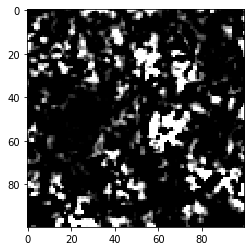

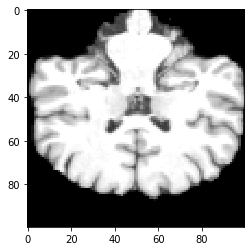

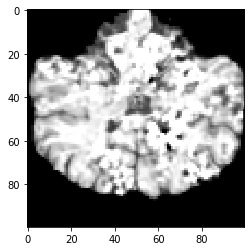

0.9999999999999997
0.9999999999999997
-2.2168933355715125e-17


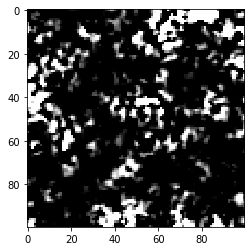

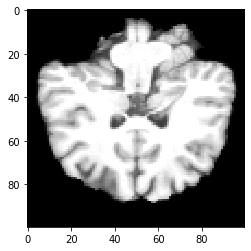

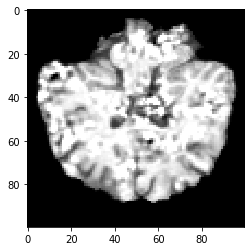

0.9999999999999997
1.0
3.552713678800501e-17


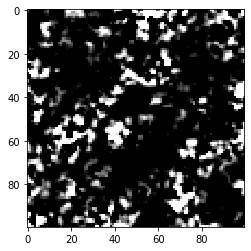

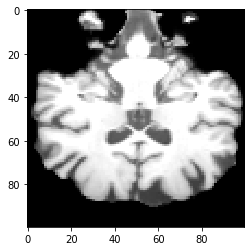

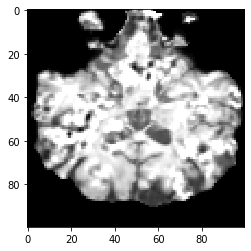

1.0
1.0
-3.230600971922589e-17


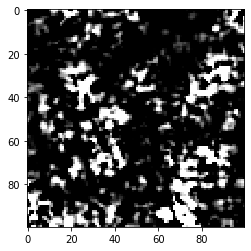

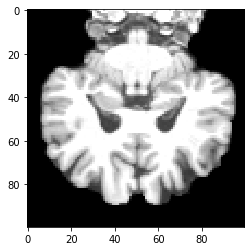

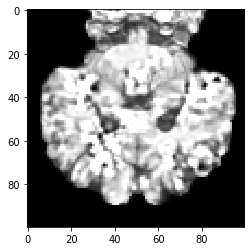

1.0
0.9999999999999997
1.152026622245709e-16


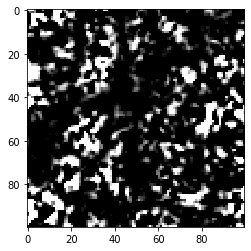

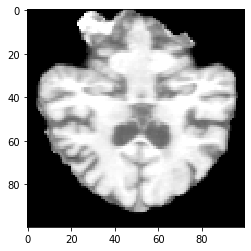

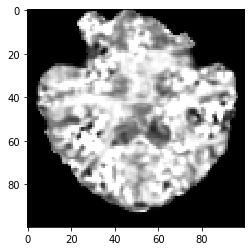

In [142]:
from scipy.ndimage import gaussian_filter
import scipy.ndimage as ndimage
i = 0
for test_images, test_labels in ds_val:
    #filtered = gaussian_filter(test_images[0,...].numpy(), sigma=3.0)
    #filtered =  ndimage.sobel(test_images[0,...].numpy())
    filtered = test_images[0,..., 0].numpy()
    rd_img = np.random.random(filtered.shape)-0.5
    rd_img = gaussian_filter(rd_img, sigma=1.0)
    rd_img  = (rd_img-np.mean(rd_img)) / np.std(rd_img)
    rd_img = rd_img / np.max(rd_img)
    rd_img2 = gaussian_filter(rd_img, sigma=6.0)
    rd_img2  = (rd_img2-np.mean(rd_img2)) / np.std(rd_img2)
    print(np.std(rd_imgc))
    rd_imgc = rd_img*rd_img2
    rd_imgc = (rd_imgc-np.mean(rd_imgc)) / np.std(rd_imgc)
    print(np.std(rd_imgc))
    print(np.mean(rd_imgc))
    #transformed['t2'][DATA] = transformed['t2'][DATA] - 0.5
    plt.imshow(rd_imgc[:, 50, :], cmap='gray', vmin=0.0, vmax=1.0)
    plt.show()
    plt.imshow(filtered[:, 50, :], cmap='gray', vmin=0.0, vmax=1.0)
    plt.show()
    #plt.imshow(transformed['t1']['data'][0, :, 50, :], cmap='gray')
    plt.imshow(filtered[:, 50, :]*(1+0.3*rd_imgc[:, 50, :]*(filtered[:, 50, :] > 0)), cmap='gray', vmin=0.0, vmax=1.0)
    plt.show()
   # plt.imshow(1+0.2*rd_imgc[:, 50, :], cmap='gray')
    i=i+1
    if i==5:
        break

In [31]:
a = np.array([1.0, 2.0, 3.0])

In [41]:
b = [2.0]
b= b + list(a)

In [42]:
b

[2.0, 1.0, 2.0, 3.0]

In [48]:
a = list(range(10))
a

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [49]:
import pandas as pd


In [50]:
dic = {'a': [0, 1, 2], 'b': [2, 3, 4]}

In [51]:
print(dic)

{'a': [0, 1, 2], 'b': [2, 3, 4]}


In [53]:
df = pd.DataFrame.from_dict(dic)

In [56]:
df.to_csv('./test.csv')

In [65]:
keras_evaluation.test()

/home/raheppt1/projects/age_prediction/reports/predictions/test.csv


In [ ]:
'/mnt/share/raheppt1/tf_models/brainage/keras/IXI_mc_dropout_01/cp494-5.18.tf/'